In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import warnings
import os, random
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import CNN
from models import RNN
from models import AUTOENCODER
from attacks import gradient_wrt_data
from attacks import FGSM_Linf_attack
from attacks import FGSM_L2_attack
from utilities import *


#from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import make_interp_spline

In [2]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  # specify which GPU(s) to be used
#device = torch.cuda.set_device(3)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print("Current Device: ", torch.cuda.current_device())

1
Current Device:  cuda
Quadro RTX 6000
Current Device:  0


In [3]:
filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

In [4]:
curr_model = "CNN"

subsample = 1
#subsample = 2
# subsample = 4
#subsample = 8

In [5]:
x_train0, x_test0, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods, NN = curr_model)

#####################################################################
x_train = x_train0[:,:,:,::subsample]
x_test = x_test0[:,:,:,::subsample]
####################################################################

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([480000, 1, 2, 128])
torch.Size([120000, 1, 2, 128])
torch.Size([480000])
torch.Size([120000])


In [6]:
if curr_model == "CNN" :
    batch_size = 256    
    if subsample == 1 : 
        model = CNN(input_size = 128).to(device = device)
        model_checkpoint = "CNN_base.pt"
    if subsample == 2 :
        model = CNN(input_size = 64).to(device = device)
        model_checkpoint = "CNN_base_sub12.pt"
    if subsample == 4 :
        model = CNN(input_size = 32).to(device = device)
        model_checkpoint = "CNN_base_sub14.pt"
    if subsample == 8 :
        model = CNN(input_size = 16).to(device = device)
        model_checkpoint = "CNN_base_sub18.pt"

num_epochs = 100
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr = 0.001)

train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test,  y_test.type(torch.LongTensor))

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

### Baseline Model Training

In [ ]:
num_epochs   = 100
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, labels)
        acc     = evaluate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    if avg_val_acc > best_val_acc :
        print("Saving Model Checkpoint......")
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

In [ ]:
##########################################################################

### Baseline Model Testing

In [55]:
cnn_net1 = CNN()
cnn_net2 = CNN(input_size=64)
cnn_net8 = CNN(input_size=16)
cnn_net1.load_state_dict(torch.load("CNN_base.pt"))
cnn_net2.load_state_dict(torch.load("CNN_base_sub12.pt"))
cnn_net8.load_state_dict(torch.load("CNN_base_sub18.pt"))
cnn_net1 = cnn_net1.to(device)
cnn_net2 = cnn_net2.to(device)
cnn_net8 = cnn_net8.to(device)

In [ ]:
cnn_acc1, cnn_loss1, y_preds1 = evaluate_model(cnn_net1, TestLoader, device)
y_test_np = y_test.cpu().numpy()
print("CNN_base Accuracy = %.4f" % cnn_acc1)
# print(type(y_preds))
# print(type(y_test_np))
# print(y_preds.shape)
# print(y_test_np.shape)

In [ ]:
plot_confusion_matrix(y_tests = y_test.cpu().numpy(), 
                      y_preds = y_preds, mods = mods)

[]

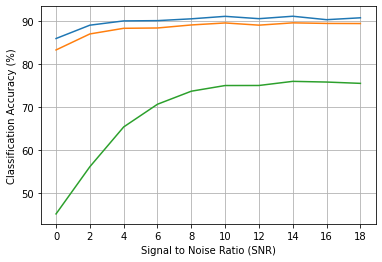

In [61]:
x_train2, x_test2 = x_train0[:,:,:,::2], x_test0[:,:,:,::2]
x_train8, x_test8 = x_train0[:,:,:,::8], x_test0[:,:,:,::8]
acc_dict1 = plot_snr_accuracy(cnn_net1, x_test0, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = 'No Samples')
acc_dict2 = plot_snr_accuracy(cnn_net2, x_test2, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = '1/2 Samples')
acc_dict8 = plot_snr_accuracy(cnn_net8, x_test8, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = '1/8 Samples')

In [ ]:
###########################################################################

### Adversarial Attacks

In [7]:
# EPS for FGSM attack
curr_attack = "FGSM_Linfinity"
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])
fgsm_acc = np.zeros(len(eps_values))
fgsm_art_acc = np.zeros(len(eps_values))

In [7]:
# EPS for FGM L2 attack
curr_attack = "FGSM_L2"
eps_values = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 
                       0.20, 0.30, 0.40, 0.50])
fgm_acc = np.zeros(len(eps_values))
fgm_art_acc = np.zeros(len(eps_values))

In [29]:
print(min(test_labels))
adv_dataset = [[[] for j in range(max(test_labels))] for i in range(len(eps_values))]
print(np.shape(adv_dataset))

0
(9, 9, 0)


In [9]:
whitebox = CNN(input_size=128)

#whitebox.load_state_dict(torch.load("CNN_base_sub12.pt"))
whitebox.load_state_dict(torch.load("CNN_base.pt"))
#whitebox.load_state_dict(torch.load("CNN_FGSM_ART_sub12.pt"))
#whitebox.load_state_dict(torch.load("CNN_FGML2_ART_sub12.pt"))

whitebox = whitebox.to(device)
whitebox.eval()
adv_dataset = [[] for i in range(len(eps_values))]
clean_dataset = [[] for i in range(len(eps_values))]

for i in range(len(eps_values)) :
    print("Current ATK_EPS Index = " + str(i + 1))
    ATK_EPS   = eps_values[i]
    whitebox_correct = 0
    running_total    = 0
    for batch_idx, (data, labels) in enumerate(TestLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        #################################################################
        if curr_attack == "FGSM_Linfinity" :
            # Fast Gradient Sign Method (FGSM) L-infinity Norm Attack
            adv_data = FGSM_Linf_attack(whitebox, device, data, 
                                        labels, eps = ATK_EPS)
            adv_labels = labels.cpu().detach().numpy()
            indx = np.where(adv_labels == 4)[0]
            adv_dataset[i].append(adv_data[indx])
            clean_dataset[i].append(data[indx])
            
        if curr_attack == "FGSM_L2" :
            # Fast Gradient Sign Method (FGSM) L-2 Norm Attack
            adv_data = FGSM_L2_attack(whitebox, device, data, labels, 
                                      eps = ATK_EPS)
            adv_labels = labels.cpu().detach().numpy()
            indx = np.where(adv_labels == 4)[0]
            adv_dataset[i].append(adv_data[indx])
            clean_dataset[i].append(data[indx])
        #################################################################
        
        # Compute accuracy on perturbed data
        with torch.no_grad() :
            whitebox_outputs  = whitebox(adv_data)
            _, whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            running_total    += labels.size(0)
    
    whitebox_acc = float(whitebox_correct) / running_total
    
    if curr_attack == "FGSM_Linfinity" :
        #fgsm_acc[i] = whitebox_acc
        fgsm_art_acc[i] = whitebox_acc
        print("fgsm_art_acc = {}".format(whitebox_acc))
    if curr_attack == "FGSM_L2" :
        #fgm_acc[i] = whitebox_acc
        fgm_art_acc[i] = whitebox_acc
        print("fgm_art_acc = {}".format(whitebox_acc))

print("Attack Done!")



Current ATK_EPS Index = 1
fgsm_art_acc = 0.9077583333333333
Current ATK_EPS Index = 2
fgsm_art_acc = 0.5297416666666667
Current ATK_EPS Index = 3
fgsm_art_acc = 0.350575
Current ATK_EPS Index = 4
fgsm_art_acc = 0.248125
Current ATK_EPS Index = 5
fgsm_art_acc = 0.14935
Current ATK_EPS Index = 6
fgsm_art_acc = 0.12344166666666667
Current ATK_EPS Index = 7
fgsm_art_acc = 0.106175
Current ATK_EPS Index = 8
fgsm_art_acc = 0.08269166666666666
Current ATK_EPS Index = 9
fgsm_art_acc = 0.09775833333333334
Attack Done!


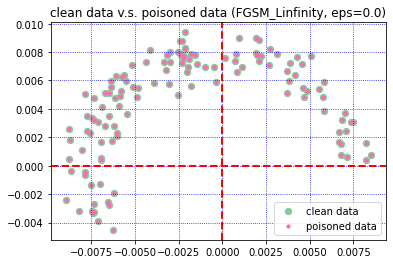

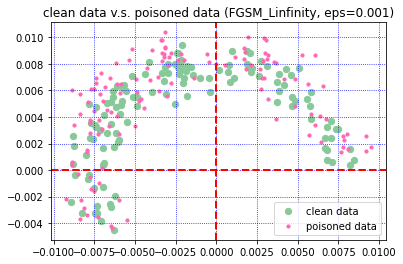

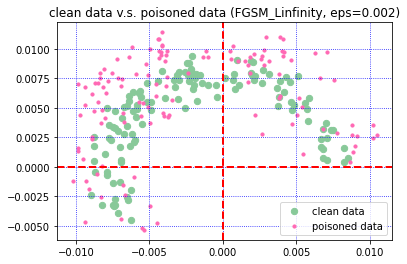

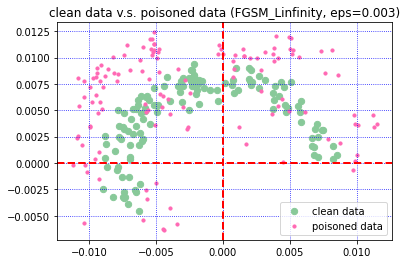

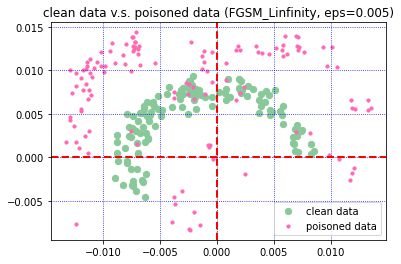

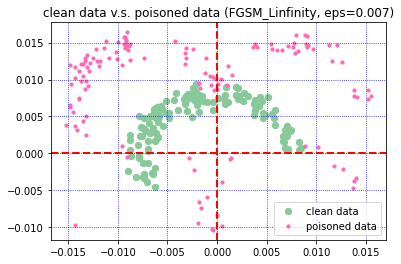

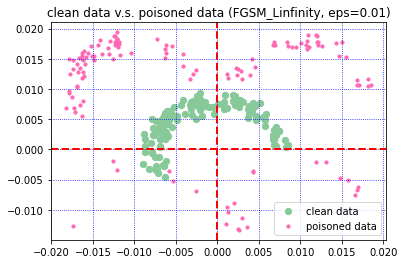

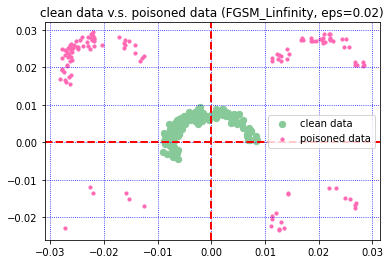

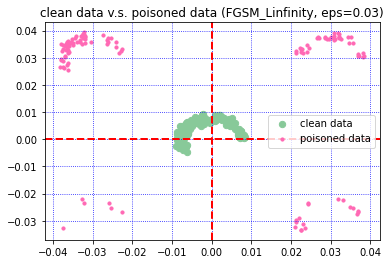

In [11]:

for i in range(len(eps_values)):
    adv = adv_dataset[i][0][0][0].cpu().detach().numpy()
    clean = clean_dataset[i][0][0][0].cpu().detach().numpy()
    plt.scatter(clean[0], clean[1], color = '#88c999', s = 40, label="clean data")
    plt.scatter(adv[0], adv[1], color = 'hotpink', s = 10, label="poisoned data")
    plt.legend()
    plt.grid(linestyle=":",color="b")
    #plt.axis(xmin=-0.01, xmax=0.01, ymin=-0.01, ymax=0.01)
    plt.axvline(x=0, c="r", ls="--", lw=2)
    plt.axhline(y=0, c="r", ls="--", lw=2)
    plt.title("clean data v.s. poisoned data ({}, eps={})".format(curr_attack,eps_values[i]), fontsize = 12)
    plt.savefig('./output1/{}_{}.png'.format(curr_attack,eps_values[i]))
    plt.show()

In [101]:
def plot_summary (base_acc, art_acc, detect_acc, eps_values, eps_values_T) :
    figure, axis = plt.subplots()
    # base_Spline = make_interp_spline(eps_values, base_acc)
    # art_Spline = make_interp_spline(eps_values, art_acc)
    detect_Spline = make_interp_spline(eps_values_T, detect_acc)
    # X0_ = np.linspace(eps_values.min(),eps_values.max(),20)
    X1_ = np.linspace(eps_values_T.min(),eps_values_T.max(),20)
    # base = base_Spline(X0_)
    # art = art_Spline(X0_)
    detect = detect_Spline(X1_)

    axis.plot(eps_values, base_acc,   label = "BASE", linewidth = 3)
    axis.plot(eps_values, art_acc,    label = "ART",  linewidth = 3)
    axis.plot(eps_values_T, detect_acc, label = "DECT", linewidth = 3)
    axis.set_xlabel("EPS", fontsize = 12)
    axis.set_ylabel("ACC", fontsize = 12)
    axis.set_title("No Subsampling", fontsize = 12)
    axis.grid()
    figure.set_size_inches(6, 4)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

In [ ]:
eps_values_0 = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

fgsm_acc = np.array([0.90775833, 0.52973333, 0.35055833, 0.248125, 0.14935, 
                     0.12344167, 0.10616667, 0.08269167, 0.09775833])

fgsm_art_acc = np.array([0.89946667, 0.66180833, 0.64145833, 0.592725,   0.49783333, 0.47271667,
                        0.42183333, 0.127275, 0.08095])

eps_values_T0 = np.array([0, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.012, 0.017, 0.022, 
                        0.027, 0.030])

detect0_acc = np.array([0, 0.007266666666666667, 0.012493333333333334, 0.03602, 0.2676733333333333, 
                       0.5352466666666666, 0.7463066666666667, 0.8421333333333333, 0.9984266666666667, 1.0, 1.0, 1.0])

eps_values_1 = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 
                       0.20, 0.30, 0.40, 0.50])

fgm_acc = np.array([0.90775833, 0.59928333, 0.49648333, 0.28905833, 
                    0.22471667, 0.20176667, 0.19169167, 0.16296667, 0.13998333, 
                    0.12625833, 0.11841667])

fgm_art_acc = np.array([0.90353333, 0.71053333, 0.65710833, 0.601575,   0.57029167, 0.54256667,
                        0.51161667, 0.28706667, 0.16754167, 0.12459167, 0.11054167])

detect1_acc = np.array([0.007655555555555555, 0.026455555555555555, 0.21103333333333332, 0.4010888888888889, 0.5513888888888889, 
                        0.6603222222222223, 0.7446, 0.8098666666666666, 0.8561555555555556, 0.8914888888888889, 0.9173222222222223])

eps_values_T1 = np.array([0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 
                       0.35, 0.4, 0.45, 0.50])



In [102]:
eps_values_0 = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

fgsm_acc = np.array([0.88895833, 0.5662,     0.46883333, 0.36074167, 0.195175,   0.13670833,
                    0.12288333, 0.09525,    0.09901667])

fgsm_art_acc = np.array([0.873,      0.62846667, 0.550975,   0.4847,     0.37970833, 0.31566667,
                    0.27445833, 0.11316667, 0.09768333])

eps_values_T0 = np.array([0, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.015, 0.02, 0.030])

detect0_acc = np.array([0.004, 0.005, 0.007, 0.026, 0.27, 0.635, 0.958, 0.970, 1, 1])

eps_values_1 = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 
                       0.20, 0.30, 0.40, 0.50])

fgm_acc = np.array([0.88895833, 0.57163333, 0.41284167, 0.257725,   0.20806667, 0.17810833,
                    0.15861667, 0.12185,    0.11030833, 0.106225,   0.1036    ])

fgm_art_acc = np.array([0.873975,   0.67265,    0.60540833,  0.5442,     0.50801667, 0.47680833,
                        0.44433333, 0.28264167, 0.19341667, 0.164425,   0.15573333])

detect1_acc = np.array([0.0051, 0.0057, 0.0125, 0.19246666666666667, 0.6787, 0.9102666666666667, 0.9721666666666666, 
                        0.9891666666666666, 0.9952333333333333, 0.9977333333333334, 0.9992666666666666])

eps_values_T1 = np.array([0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 
                       0.35, 0.4, 0.45, 0.50])

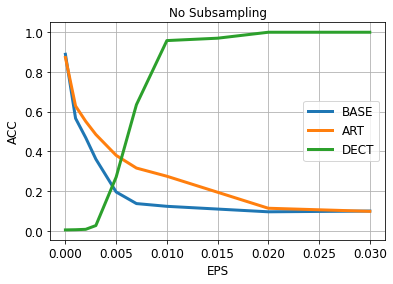

In [103]:

plot_summary(fgsm_acc, fgsm_art_acc, detect0_acc, eps_values_0, eps_values_T0)

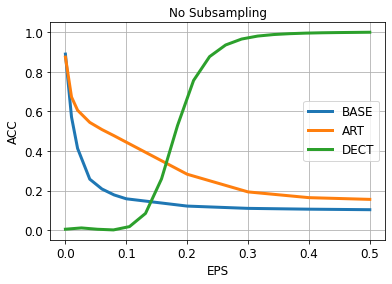

In [90]:
plot_summary(fgm_acc, fgm_art_acc, detect1_acc, eps_values_1, eps_values_T1)

In [ ]:
#########################################################################

### Adversarial Retraining (Mitigation) & Manifold Learning (Detection)

In [82]:
model = CNN(input_size = 64)
model.load_state_dict(torch.load("CNN_base_sub12.pt"))
model = model.to(device)
#model_checkpoint = "CNN_FGSM_ART_sub12.pt"
model_checkpoint = "CNN_FGML2_ART_sub12.pt"

num_epochs   = 5
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # #######################################################################
        # # FGSM L-infinity Adversarial Retraining
        # adv1_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.001)
        # adv2_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.002)
        # adv3_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.003)
        # adv4_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.005)
        # adv5_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.007)
        # adv6_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.010)
        
        # adjdata = torch.vstack((adv1_data, adv2_data, adv3_data, 
        #                         adv4_data, adv5_data, adv6_data))
        # adjlabels = torch.cat((labels, labels, labels, 
        #                        labels, labels, labels))
        
        # outputs = model(adjdata)
        # loss = criterion(outputs, adjlabels)
        # acc = evaluate_accuracy(outputs, adjlabels)
        # #######################################################################
        
        #######################################################################
        # FGSM L-2 Adversarial Retraining
        adv1_data = FGSM_L2_attack(model, device, data, labels, eps = 0.01)
        adv2_data = FGSM_L2_attack(model, device, data, labels, eps = 0.02)
        adv3_data = FGSM_L2_attack(model, device, data, labels, eps = 0.04)
        adv4_data = FGSM_L2_attack(model, device, data, labels, eps = 0.06)
        adv5_data = FGSM_L2_attack(model, device, data, labels, eps = 0.08)
        adv6_data = FGSM_L2_attack(model, device, data, labels, eps = 0.10)
        
        adjdata = torch.vstack((adv1_data, adv2_data, adv3_data, 
                                adv4_data, adv5_data, adv6_data))
        adjlabels = torch.cat((labels, labels, labels, 
                               labels, labels, labels))
        
        outputs = model(adjdata)
        loss = criterion(outputs, adjlabels)
        acc = evaluate_accuracy(outputs, adjlabels)
        #######################################################################
        
        
        
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    #torch.save(model.state_dict(), model_checkpoint)
    
    if avg_val_acc > best_val_acc :
        print("Saving Model Checkpoint......")
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), model_checkpoint)

print("Adversarial Retraining Complete!")

Epoch 1: | Train Acc: 51.709 | Test Acc: 86.966
Saving Model Checkpoint......
Epoch 2: | Train Acc: 55.917 | Test Acc: 86.891
Epoch 3: | Train Acc: 56.921 | Test Acc: 87.064
Saving Model Checkpoint......
Epoch 4: | Train Acc: 57.379 | Test Acc: 87.002
Epoch 5: | Train Acc: 57.721 | Test Acc: 87.384
Saving Model Checkpoint......
Adversarial Retraining Complete!


### Autoencoder Training

In [ ]:
model = AUTOENCODER()
model.to(device)
model_checkpoint = "AUTOENCODER.pt"

num_epochs = 100
criterion  = nn.MSELoss()
optimizer  = optim.SGD(model.parameters(), lr = 0.001)
batch_size = 256

train_dataset = TensorDataset(x_train, x_train)
test_dataset  = TensorDataset(x_test,  x_test)

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

best_val_loss = 1.

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    for batch_idx, (data, lbs) in enumerate(TrainLoader) :
        data   = data.to(device)
        lbs = lbs.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, lbs)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_loss:.4e} | Test Acc: {avg_val_loss:.4e}')
    
    if avg_val_loss < best_val_loss :
        print("Saving Model Checkpoint......")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

### Constructing AMC Adversarial Detector

In [ ]:
# EPS for FGSM attack
curr_attack = "FGSM_Linfinity"
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

x_train, x_test, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods)

train_dataset = TensorDataset(x_train, x_train)
test_dataset  = TensorDataset(x_test,  x_test)
batch_size = 16
TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

model = CNN(input_size = 128)
model.load_state_dict(torch.load("CNN_base.pt"))
model = model.to(device)
encoder = AUTOENCODER()
encoder.load_state_dict(torch.load("AUTOENCODER.pt"))
encoder.to(device)
criterion  = nn.MSELoss()

T = []
for eps in eps_values:
    E = []
    for batch_idx, (data, lbs) in enumerate(TrainLoader) :
        data = data.to(device)
        lbs = lbs.to(device)

        #FGSM L-infinity Adversarial Retraining
        adv_data = FGSM_Linf_attack(model, device, data, labels, eps)

        outputs = encoder(adv_data)
        loss = criterion(outputs,lbs)
        E.append(loss)
    
    T.append(max(E))

### Applying AMC Adversarial Detector

In [ ]:
encoder = AUTOENCODER()
encoder.load_state_dict(torch.load("AUTOENCODER.pt"))
encoder.to(device)

encoder.eval()

dtct_rate = []
for i in range(len(eps_values)) 
    detect_num = 0
    all_num = 0
    for X_val_batch, y_val_batch in TestLoader :
        X_val_batch = X_val_batch.to(device)
        y_val_batch = y_val_batch.to(device)
        
        adv_x = FGSM_Linf_attack(model, device, x_val_batch, y_val_batch, eps)
        y_val_pred = encoder(adv_x)
        val_loss = criterion(y_val_pred, adv_x)

        if val_loss > T:
            detect_num += 1
        all_num += 1
    
    detection_rate = float(detect_num) / float(all_num)  
    print(f'eps value {eps_values[i]}: Detection rate: {detection_rate:.3f}')   
    dtct_rate.append(detection_rate)

print(dict_rate)
